# Example: What is the Extrinsic Value of an Option Contract?
In this example, we will compute the intrinsic and extrinsic values of various option contracts using real market data for NVIDIA (NVDA) options.

> __Learning Objectives:__
>
> By the end of this example, you should be able to:
> * __Decompose option premiums into intrinsic and extrinsic values:__ Separate the immediate exercise value from the time value of an option to understand what portion of the premium reflects present value versus future potential.
> * __Analyze how time to expiration affects extrinsic value:__ Examine the relationship between time remaining until expiration and extrinsic value, and observe how extrinsic value decays as expiration approaches.
> * __Evaluate option value across different strike prices:__ Compute and compare option premiums across a range of strike prices to understand how moneyness affects the split between intrinsic and extrinsic value.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the data in the `metadata::Dict{String,Any}` and `optionschain::DataFrame` variables.

In [2]:
metadata, optionschain = let
    
    # initialize -
    options_dataset = MyOptionsChainDataSet(ticker="nvda");
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain) # return
end;

What's in the metadata dictionary?

In [3]:
metadata |> keys

KeySet for a Dict{String, Any} with 10 entries. Keys:
  "DTE"
  "purchase_date"
  "historical_volatility"
  "underlying_share_price_ask"
  "source"
  "underlying_share_price_bid"
  "is_weekly"
  "atm_IV"
  "expiration_date"
  "underlying_share_price_mid"

What about the optionschain variable?

In [4]:
optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,String7
1,0.5,0.998,206.0,206.7,207.4,209.58,37,62498,7.044,0.9997,Call
2,1.0,0.995,205.6,206.85,208.1,206.09,1356,13384,4.682,0.9998,Call
3,1.5,0.993,204.0,205.63,207.25,193.52,0,1611,4.515,0.9996,Call
4,2.0,0.99,204.4,205.1,205.8,203.9,14,16079,3.937,0.9997,Call
5,2.5,0.988,202.8,204.55,206.3,187.37,0,663,0.0,0.0,Call
6,3.0,0.986,203.4,204.25,205.1,178.6,0,2070,4.227,0.9991,Call
7,3.5,0.983,202.0,203.75,205.5,189.4,0,5,4.017,0.999,Call
8,4.0,0.981,201.5,203.25,205.0,173.4,0,50,3.84,0.999,Call
9,4.5,0.978,201.0,202.75,204.5,173.28,0,1,3.686,0.999,Call


### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [5]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64,x); # set the initial share price (this has no importance now because we have the options chain data)
DTE = metadata["DTE"] |> x-> parse(Float64,x); # set the days to expiration
Δt = (1/365); # natural time-scale is days
T = (DTE) * Δt; # days to the expiration of the contract
r̄ = 0.040; # risk-free rate
h = 5*DTE |> Int64; # number of levels of the tree, n-points per day

What is the current share price of NVDA?

In [13]:
println("The current share price Sₒ is: $(Sₒ) USD/share");

The current share price Sₒ is: 207.04 USD/share


___

## Task 1: Select an At The Money (ATM) Contract to Explore
In this task, we'll select an option contract from the options chain data to explore its intrinsic and extrinsic values. We could choose any contract, but for this example, let's pick the at-the-money (ATM) call option.

We'll save this data in the `call_option_data::DataFrame` variable:

In [ ]:
call_option_data = let

    # initialize -
    δ = 0.05; # set the delta for ATM search

    # first, filter the options chain to get only call options -
    call_options_chain = filter(row -> row[:Type] == "Call", optionschain);

    # Next, let's find contracts that are at-the-money (ATM) or near-the-money (NTM) -
    atm_call_options = filter(row -> abs((row[:Strike] - Sₒ)/Sₒ) < δ, call_options_chain);
end

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,String7
1,200.0,0.034,22.0,22.13,22.25,22.0,12314,74178,0.456,0.622,Call
2,205.0,0.01,19.3,19.45,19.6,19.25,6490,28849,0.456,0.5773,Call
3,210.0,-0.014,16.85,17.03,17.2,17.0,18554,31038,0.453,0.5324,Call
4,212.0,-0.024,15.95,16.38,16.8,15.95,1524,5818,0.449,0.5139,Call
5,213.0,-0.029,15.5,15.63,15.75,15.46,390,1953,0.451,0.5054,Call
6,214.0,-0.034,15.1,15.23,15.35,15.1,400,3581,0.448,0.496,Call
7,215.0,-0.038,14.65,14.8,14.95,14.8,6787,19930,0.451,0.4877,Call
8,216.0,-0.043,14.25,14.4,14.55,14.15,386,3514,0.451,0.479,Call
9,217.0,-0.048,13.85,14.0,14.15,13.95,263,3782,0.449,0.4698,Call


Select a specific ATM call contract and compute its premium using the CRR binomial model. The code builds a CRR tree, prices the contract using backward induction, then calculates intrinsic and extrinsic values. Returns `P::Float64` (premium), `EV::Float64` (extrinsic value), `InV::Float64` (intrinsic value), `IV::Float64` (implied volatility), and `index::Int64` (contract index).

In [30]:
P, EV, InV, IV, index = let

    # initialize -
    data = call_option_data;
    θ = 1; # long position
    i = 9; # specify the index of the contract to analyze
    K = data[i,:Strike]; # strike price
    IV = data[i,:IV]; # implied volatility
    mid = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), data)[1,:Mid];
    bid = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), data)[1,:Bid];
    ask = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), data)[1,:Ask];
   
    # build the model -
    contract_model = build(MyAmericanCallContractModel, (
        K = K, premium = 0.0, sense = θ, copy = 1
    ));

    # build the tree for a contract i. Note the two step process: first we build an (empty) tree structure, then we populate it with future share price data
    tree_model = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = r̄, T = T, σ = IV)) |> (x-> populate(x, Sₒ = Sₒ, h = h));

    # compute the premium for a contract i
    P = premium(contract_model, tree_model); # this method is doing the backward induction on the CRR tree

    # Compute intrinsic value and extrinsic value
    InV = max(0, Sₒ - K); # intrinsic value for a call option
    EV = P - InV; # extrinsic value

    (P, EV, InV, IV, i) # return
end;

Create a formatted table displaying the selected contract's properties. The table shows the strike price, implied volatility, bid/ask prices, computed premium, intrinsic value, and extrinsic value. This provides a clear summary of how the premium breaks down into its components.

In [32]:
let

    # initialize -
    data = call_option_data;
    i = index; # specify the index of the contract to analyze
    K = data[i,:Strike]; # strike price
    IV = data[i,:IV]; # implied volatility
    mid = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), data)[1,:Mid];
    bid = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), data)[1,:Bid];
    ask = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), data)[1,:Ask];
    df = DataFrame();

    # populate the data for the table -
    row_df = (
        type = "Call",
        strike = K,
        implied_volatility = IV,
        bid = bid,
        ask = ask,
        mid = mid,
        premium = P,
        intrinsic_value = InV,
        extrinsic_value = EV
    );
    push!(df, row_df);

    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_horizontally = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end;

 -------- --------- -------------------- --------- --------- --------- --------- ----------------- -----------------
    type    strike   implied_volatility       bid       ask       mid   premium   intrinsic_value   extrinsic_value 
  String   Float64              Float64   Float64   Float64   Float64   Float64           Float64           Float64 
 -------- --------- -------------------- --------- --------- --------- --------- ----------------- -----------------
    Call     217.0                0.449     13.85     14.15      14.0     13.93               0.0             13.93
 -------- --------- -------------------- --------- --------- --------- --------- ----------------- -----------------


### Discussion
* __Hmmm__. For some of these contracts, the intrinsic value (the immediate exercise value of the contract) is zero, but we are willing to pay a non-zero premium for the contract, i.e., the contract has non-zero extrinsic value. Why are we willing to pay something for a contract that is worthless if exercised immediately?  
___

## Task 2: How does the time to expiration affect extrinsic value?
We now understand how a single contract's premium decomposes into intrinsic and extrinsic components. Let's explore how this decomposition changes as we vary the time to expiration and strike price across a range of hypothetical contracts.

We started out describing extrinsic value as the "time value" of an option contract. So, how does the time to expiration affect the extrinsic value? 

> __Moneyness:__ Moneyness describes the relationship between the current underlying asset price and the strike price. A call option is __in-the-money__ (ITM) when $S(t) > K$, __at-the-money__ (ATM) when $S(t) \approx K$, and __out-of-the-money__ (OTM) when $S(t) < K$. For a put option, these relationships are reversed.

Compute premiums for call contracts across a range of strike prices and times to expiration using the CRR binomial model. 

For each combination of DTE (days to expiration) and strike price, a CRR tree is built and the contract is priced. Returns `premium_matrix::Array{Float64,2}` (premiums indexed by strike price and DTE), `DTEV::Vector{Float64}` (vector of DTE values), and `SPV::Vector{Float64}` (vector of strike prices).

In [33]:
premium_matrix, DTEV, SPV = let

    # initialize -
    δ = 0.5;
    number_of_DTE_values = 5;
    number_of_strike_prices = 25;
    DTE_values_vector = range(1, stop=DTE, length=number_of_DTE_values) |> collect;
    strike_prices_vector = range(Sₒ*(1-δ), stop=Sₒ*(1+δ), length=number_of_strike_prices) |> collect;
    premium_matrix = zeros(number_of_strike_prices, number_of_DTE_values);

    for i ∈ eachindex(DTE_values_vector)

        # set the time to expiration -
        DTE_i = DTE_values_vector[i];
        T_i = DTE_i * Δt;

        for j ∈ eachindex(strike_prices_vector)

            # set the strike price -
            K_j = strike_prices_vector[j];

            # build the model -
            contract_model = build(MyAmericanCallContractModel, (
                K = K_j, premium = 0.0, sense = 1, copy = 1
            ));

            # build the tree for a contract i. Note the two step process: first we build an (empty) tree structure, then we populate it with future share price data
            tree_model = build(MyAdjacencyBasedCRREquityPriceTree, 
                (μ = r̄, T = T_i, σ = IV)) |> (x-> populate(x, Sₒ = Sₒ, h = h));

            # compute the premium for a contract i
            P_ij = premium(contract_model, tree_model); # this method is doing the backward induction on the CRR tree

            # store in matrix -
            premium_matrix[j,i] = P_ij;
        end
    end

    premium_matrix, DTE_values_vector, strike_prices_vector # return
end;

Next, let's compute the intrinsic value of the option contracts. We'll save the intrinsic value data in the `intrinsic_array::Array{Float64,2}` variable.

The first column holds the strike prices, and the second column holds the intrinsic values.

In [15]:
intrinsic_array = let

    # initialize -
    number_of_strike_prices = size(premium_matrix, 1);
    intrinsic_array = zeros(number_of_strike_prices, 2);

    for i ∈ eachindex(SPV)
        K = SPV[i];
        intrinsic_array[i,1] = K;
        intrinsic_array[i,2] = max(0, Sₒ - K);
    end
    
    intrinsic_array # return
end

25×2 Matrix{Float64}:
 103.52   103.52
 112.147   94.8933
 120.773   86.2667
 129.4     77.64
 138.027   69.0133
 146.653   60.3867
 155.28    51.76
 163.907   43.1333
 172.533   34.5067
 181.16    25.88
   ⋮      
 241.547    0.0
 250.173    0.0
 258.8      0.0
 267.427    0.0
 276.053    0.0
 284.68     0.0
 293.307    0.0
 301.933    0.0
 310.56     0.0

Create a plot showing option premiums across different strike prices and times to expiration. 

> __What are we going to see?__ Each curve represents a different DTE value, with longer-dated contracts shown in lighter shades. The red dashed line shows the intrinsic value, and the vertical gray line marks the current share price. 

This visualization reveals how extrinsic value (the gap between premium and intrinsic value) varies with both strike price and time to expiration.

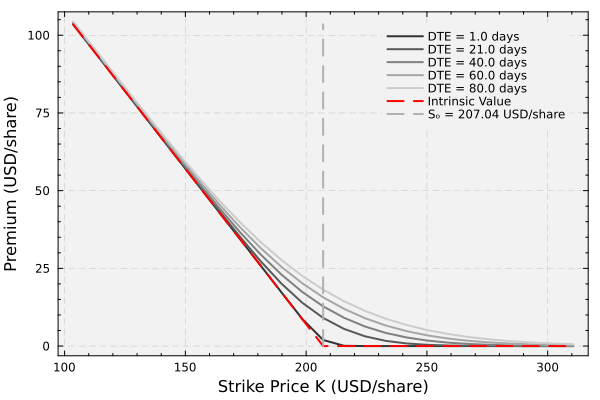

In [28]:
let

    # initialize -
    number_of_steps = 100;
    number_of_DTE_values = length(DTEV);
    colors = [RGB(0.2 + 0.6*(i-1)/(number_of_DTE_values-1), 0.2 + 0.6*(i-1)/(number_of_DTE_values-1), 0.2 + 0.6*(i-1)/(number_of_DTE_values-1)) for i in 1:number_of_DTE_values];

    # initialize -
    (number_of_strike_prices, number_of_DTE_values) = size(premium_matrix);
    q = plot();
    for i ∈ 1:number_of_DTE_values
        DTE_value = DTEV[i];
        plot!(q, SPV, premium_matrix[:,i], label="DTE = $(round(DTE_value)) days", lw=2, c=colors[i]);
    end

    plot!(q, intrinsic_array[:,1], intrinsic_array[:,2], 
        label="Intrinsic Value", lw=2, ls=:dash, color=:red);

    # current share price line -
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(0, stop = maximum(intrinsic_array[1,:]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        xminorticks=true, yminorticks=true, grid = :both, gridstyle = :dash, legend=:topright);  
    xlabel!(q, "Strike Price K (USD/share)");
    ylabel!(q, "Premium (USD/share)");

    display(q)
end

### Discussion
* __Hmmmm__. The long-dated contracts have higher extrinsic values than the short-dated contracts (even though they have the same strike prices and intrinsic values). Why is this the case?
* __Curious__. Why does the premium collapse to the intrinsic value as we get far away from the current share price, i.e., out of the money (for very high strike prices), or deep in the money (for very low strike prices) for a call option contract?
___

## Summary
This example demonstrates how option premiums split into intrinsic and extrinsic components, and how extrinsic value responds to changes in time to expiration and strike price.

> __Key Takeaways:__
>
> * __Extrinsic value represents time value:__ The difference between an option's premium and its intrinsic value is the extrinsic value, which reflects the market's assessment of future price movement potential over the remaining time until expiration.
> * __Time decay affects extrinsic value:__ Options with longer time to expiration have greater extrinsic value than shorter-dated options with the same strike, even when intrinsic values are identical. This reflects the greater opportunity for the underlying price to move favorably.
> * __Moneyness influences value decomposition:__ At-the-money and near-the-money options have significant extrinsic value relative to their total premium, while deep out-of-the-money or deep in-the-money options have premiums that approach their intrinsic values with little extrinsic value.

Understanding the components of option value provides insight into how market expectations and time affect option pricing.
___

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.